In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../modeldata/addZcrit.csv')

In [3]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [4]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 6.02 s, sys: 96.1 ms, total: 6.11 s
Wall time: 6.11 s


In [5]:
dataset['EMavg'] = (dataset['EMcrossfar']+dataset['EMcrossnear']+dataset['EMcrossouter'])/3

In [6]:
dataset['Widavg']= (dataset['MMRstrengthWnear']+dataset['MMRstrengthWfar']+dataset['MMRstrengthWouter'])/3

In [7]:
dataset.describe()


,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPnear,EMfar,EPfar,EMouter,EPouter,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
count,138543.000000,138543.000000,1.385430e+05,138543.000000,1.385430e+05,1.385430e+05,138543.000000,1.385430e+05,138543.000000,1.385430e+05,...,138543.000000,138543.000000,1.385430e+05,138543.000000,1.385430e+05,1.385430e+05,1.385430e+05,138543.0,138543.000000,1.385430e+05
mean,69271.000000,0.150181,3.176126e+00,0.039337,9.278925e-03,1.040808e-02,0.362667,1.600760e+00,0.006330,7.026640e-03,...,0.034020,0.061317,3.329871e-02,0.065760,3.626324e-02,2.863147e+08,2.925407e+08,0.0,0.363786,7.177914e-03
std,39994.063509,0.112919,1.869035e+02,0.719628,9.971464e-02,1.022660e-01,0.203083,1.269422e+02,0.018816,1.014800e-02,...,0.039827,0.071617,4.547672e-02,0.077483,5.263830e-02,4.371732e+08,4.417942e+08,0.0,0.208478,3.432201e-02
min,0.000000,0.004612,1.849842e-10,0.000000,4.213181e-14,2.116006e-13,0.006545,2.656761e-12,0.000000,1.979369e-14,...,0.000002,0.000004,1.341046e-07,0.000002,9.222669e-07,3.464102e-02,0.000000e+00,0.0,0.008290,6.346495e-08
25%,34635.500000,0.072493,5.643339e-02,0.006317,1.716468e-03,1.787210e-03,0.201376,6.901479e-03,0.000179,1.275322e-03,...,0.008006,0.015808,4.774110e-03,0.016292,4.986634e-03,6.485543e+04,5.858617e+04,0.0,0.204712,2.008686e-03
50%,69271.000000,0.118127,1.883910e-01,0.015945,4.488050e-03,4.492382e-03,0.320830,2.678360e-02,0.001739,3.530913e-03,...,0.020615,0.037513,1.703390e-02,0.039728,1.740956e-02,1.484704e+06,1.498063e+06,0.0,0.320697,4.329146e-03
75%,103906.500000,0.186970,6.721164e-01,0.031611,1.087975e-02,1.037116e-02,0.491676,9.561061e-02,0.006847,8.903005e-03,...,0.044985,0.079962,4.351152e-02,0.085537,4.580820e-02,1.000000e+09,1.000000e+09,0.0,0.480999,8.717744e-03
max,138542.000000,0.982453,6.151829e+04,238.997268,3.495459e+01,2.064828e+01,1.194679,4.028690e+04,3.251414,4.899060e-01,...,0.744225,0.995489,7.694002e-01,1.018244,9.965833e-01,1.000050e+09,1.000050e+09,0.0,1.729078,1.169559e+01


In [60]:


twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']



MMRDATAplus = ['MMRstrengthnear','MMRstrengthfar','MMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd','added'
           ]+twoBRwidth

TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

testfew = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter', 'threeBRfillfac','EMcrossnear','EMcrossfar','EMcrossouter']

testavg = ['EMavg','Widavg','threeBRfillfac']

orbital = []
e = []
a = []
P = []
pomega = []
Omega = []
w = []
m = []
for x in ['1','2','3']:
    e.append('e'+x)
    a.append('a'+x)
    P.append('P'+x)
    pomega.append('pomega'+x)
    Omega.append('Omega'+x)
    w.append('w'+x)
    m.append('m'+x)
orbital = e + a + P + pomega + Omega + w + m

MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd', "3BRfirstfillfac",
           'Zval12','Zval23','Zcrit12','Zcrit23']+twoBRwidth+e

noEM = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','eccMag','eccDir','pomegastd', "3BRfirstfillfac"
           ]+twoBRwidth


mini = ['threeBRfillfac','Zval12','Zval23','Zcrit12','Zcrit23','MMRstrengthnear','MMRstrengthfar']

In [9]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [10]:
filtData['added'] = filtData['threeBRfillfac']+filtData['3BRfirstfillfac']

In [11]:
plot = filtData
plot['dup']=plot[['threeBRfillfac','EMcrossnear','instability_time','MEGNO']].duplicated()
plot = plot.drop(plot[plot['dup']==True].index)

In [12]:
scrambled = plot.sample(frac=1)

In [13]:
scrambled = scrambled.reset_index()

In [14]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,added,dup
0,5954,5954,0.221607,0.133938,0.018384,0.018856,0.013295,0.643527,0.006575,0.000000,...,0.083402,True,False,1.037349e+08,4.771737e+07,0,0.624292,0.015869,0.214729,False
1,67286,67286,0.167389,0.057968,0.007821,0.008309,0.004905,0.185727,0.061016,0.026455,...,0.032099,True,False,1.656748e+04,3.742525e+04,0,0.245774,0.005487,0.552520,False
2,75561,75561,0.143902,0.102944,0.029017,0.003573,0.009567,0.597962,0.165930,0.000000,...,0.011309,True,False,2.642074e+04,5.545240e+04,0,0.523259,0.005329,1.354556,False
3,121014,121014,0.047127,0.881091,0.015156,0.002320,0.002332,0.128997,0.157546,0.001566,...,0.002137,True,False,3.473763e+04,5.217166e+04,0,0.119443,0.001216,3.917932,False
4,131227,131227,0.033438,0.051983,0.042978,0.001087,0.000124,0.182430,1.212912,0.015218,...,0.008691,True,False,1.225918e+04,7.494307e+03,0,0.145945,0.003618,23.369793,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127556,50533,50533,0.146226,0.323454,0.073071,0.005395,0.010457,0.198151,0.146283,0.096472,...,0.036651,True,False,6.845806e+04,8.298948e+04,0,0.239243,0.005992,0.725509,False
127557,99534,99534,0.073255,0.224595,0.014613,0.004075,0.004126,0.085168,13.551565,0.020782,...,0.015630,True,False,7.810936e+04,3.632952e+04,0,0.107695,0.003086,2.139265,False
127558,23022,23022,0.182195,0.527253,0.009199,0.000047,0.000421,0.447370,0.034285,0.009010,...,0.000198,True,True,1.000005e+09,1.000005e+09,0,0.446879,0.002513,0.070133,False
127559,59801,59801,0.100823,0.022965,0.007465,0.000201,0.000684,0.105966,0.022130,0.003355,...,0.022232,True,True,1.000000e+09,1.000000e+09,0,0.141421,0.000881,0.141370,False


In [35]:
scrambled = scrambled.drop(scrambled[scrambled['Zcrit12']>1e5].index)
scrambled = scrambled.drop(scrambled[scrambled['Zcrit23']>1e5].index)


In [36]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,added,dup
0,5954,5954,0.221607,0.133938,0.018384,0.018856,0.013295,0.643527,0.006575,0.000000,...,0.083402,True,False,1.037349e+08,4.771737e+07,0,0.624292,0.015869,0.214729,False
1,67286,67286,0.167389,0.057968,0.007821,0.008309,0.004905,0.185727,0.061016,0.026455,...,0.032099,True,False,1.656748e+04,3.742525e+04,0,0.245774,0.005487,0.552520,False
2,75561,75561,0.143902,0.102944,0.029017,0.003573,0.009567,0.597962,0.165930,0.000000,...,0.011309,True,False,2.642074e+04,5.545240e+04,0,0.523259,0.005329,1.354556,False
3,121014,121014,0.047127,0.881091,0.015156,0.002320,0.002332,0.128997,0.157546,0.001566,...,0.002137,True,False,3.473763e+04,5.217166e+04,0,0.119443,0.001216,3.917932,False
4,131227,131227,0.033438,0.051983,0.042978,0.001087,0.000124,0.182430,1.212912,0.015218,...,0.008691,True,False,1.225918e+04,7.494307e+03,0,0.145945,0.003618,23.369793,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127556,50533,50533,0.146226,0.323454,0.073071,0.005395,0.010457,0.198151,0.146283,0.096472,...,0.036651,True,False,6.845806e+04,8.298948e+04,0,0.239243,0.005992,0.725509,False
127557,99534,99534,0.073255,0.224595,0.014613,0.004075,0.004126,0.085168,13.551565,0.020782,...,0.015630,True,False,7.810936e+04,3.632952e+04,0,0.107695,0.003086,2.139265,False
127558,23022,23022,0.182195,0.527253,0.009199,0.000047,0.000421,0.447370,0.034285,0.009010,...,0.000198,True,True,1.000005e+09,1.000005e+09,0,0.446879,0.002513,0.070133,False
127559,59801,59801,0.100823,0.022965,0.007465,0.000201,0.000684,0.105966,0.022130,0.003355,...,0.022232,True,True,1.000000e+09,1.000000e+09,0,0.141421,0.000881,0.141370,False


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [37]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [38]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [39]:
realTest = test.loc[test['prelimStable']==True]

In [40]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [41]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
train[['Zval12','Zval23','Zcrit12','Zcrit23']].max()

Zval12         0.703917
Zval23         0.465614
Zcrit12    99353.735375
Zcrit23    97947.989110
dtype: float64

In [61]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 200,
                         scale_pos_weight=resultBalance)

In [62]:
testModel.fit(train[mini], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [64]:
resPred = testModel.predict_proba(tT[mini])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[mini]), tT["Stable"]))

0.8904692824621746
0.789570119802678


In [58]:
tT.value_counts('Stable')

Stable
False    7300
True     6890
Name: count, dtype: int64

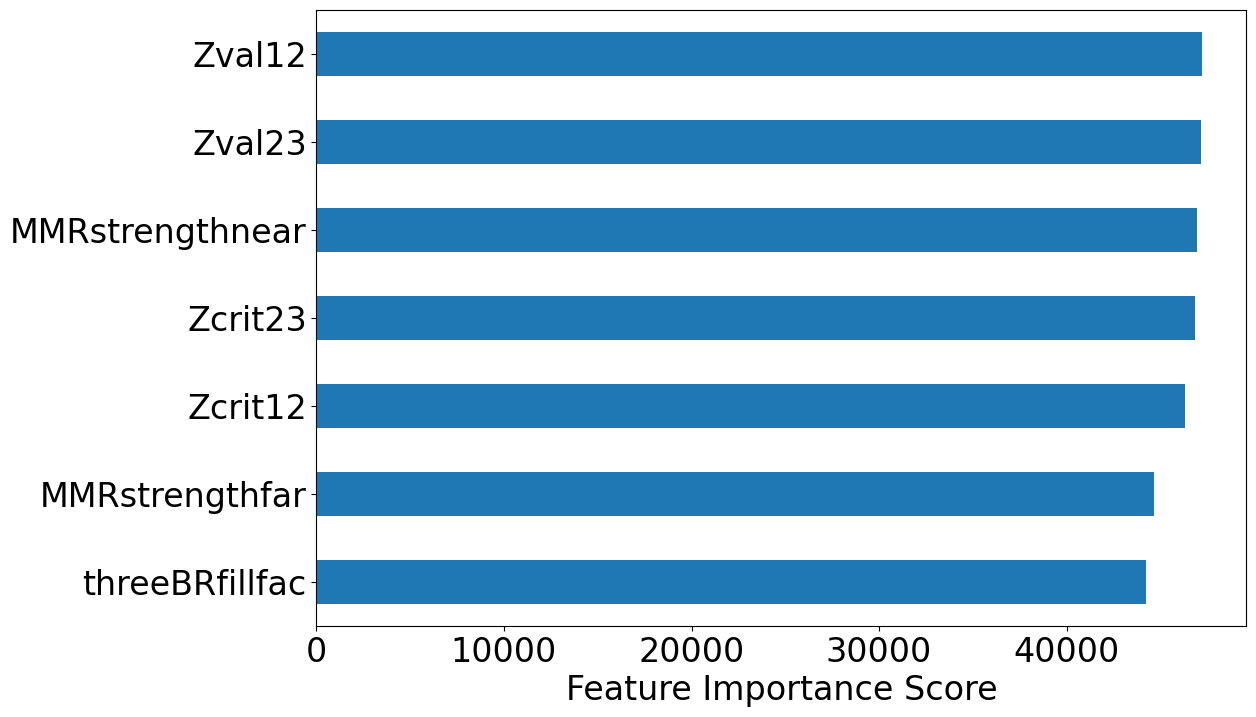

In [65]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')